<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Neural Networks and the Art Market: A Deep Learning Approach to Valuation
#   **Numerical-features-only model**

**1. Library and data import**

In [79]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



drive.mount('/content/drive')
artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
artwork_numeric_data = pd.read_excel(artist_data_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
print(artwork_numeric_data.dtypes)

category               object
sale_year               int64
sale_year_semi        float64
sale_price              int64
artist                 object
purchase_year           int64
purchase_year_semi    float64
purchase_price          int64
auction_interval      float64
return_value          float64
artist_num              int64
title                  object
sale_low_est            int64
sale_high_est           int64
purchase_low_est        int64
purchase_high_est       int64
height                  int64
width                   int64
medium                 object
sale_date              object
purchase_date          object
mtm                     int64
sale_house             object
purchase_house         object
sale_lot               object
purchase_lot           object
image_url              object
dtype: object


**2. Data preprocessing**

In [84]:
def repeated_to_single_transactions(df):
    """
    Transforms a dataset by splitting purchase and sale data into separate rows
    and renaming columns for consistency.
    """
    # Columns to keep (common info)
    common_columns = ['category', 'artist', 'height', 'width', 'medium']

    # Sale Data: Keep only relevant columns
    sale_data = df[common_columns + ['sale_year_semi', 'sale_price',
                                     'sale_house']].copy()
    sale_data = sale_data.rename(columns={
        'sale_year_semi': 'transaction_year_semi',
        'sale_price': 'transaction_price',
        'sale_house': 'transaction_house'
    })


    # Purchase Data: Keep only relevant columns
    purchase_data = df[common_columns + ['purchase_year_semi', 'purchase_price',
                                         'purchase_house']].copy()
    purchase_data = purchase_data.rename(columns={
        'purchase_year_semi': 'transaction_year_semi',
        'purchase_price': 'transaction_price',
        'purchase_house': 'transaction_house'
    })

    final_df = pd.concat([sale_data, purchase_data], ignore_index=True)

    return final_df


def one_hot(data, vars):
  # one-hot encoding for various categorical variables
  df = data.copy()
  return pd.get_dummies(df, columns=vars).astype(int)


def data_filter(data, vars, min_price=5000):
    df = data.copy()
    df.dropna(axis=0, how='any', inplace=True)
    df = df[df['transaction_price'] >= min_price]

    return df[vars]



**3.Data distributions**


Minimum category occurence is 75
Minimum sale_year_semi occurence is 95


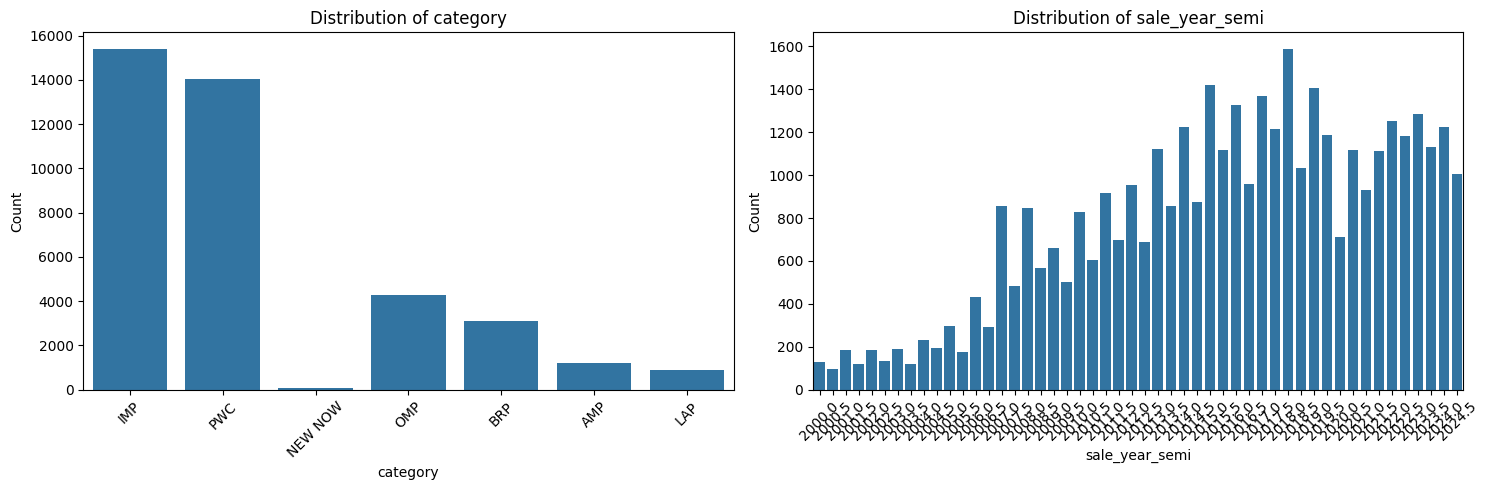

In [ ]:
# List of categorical variables
categorical_columns = ['category', 'sale_year_semi']


# get minimum occurence per variable
for idx, var in enumerate(categorical_columns):
  counts = artwork_numeric_data[var].value_counts()
  print(f"Minimum {var} occurence is {min(counts)}")



# visualize distribution of categorical variables
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(15, 5))


for i, column in enumerate(categorical_columns):
    ax = axes[i]
    sns.countplot(x=column, data=artwork_numeric_data, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()




**4. Data split**

In [83]:
def data_split(data, selected_vars, one_hot_vars, date_filter):

    df = data.copy()
    df = repeated_to_single_transactions(df)
    df = data_filter(df, selected_vars)
    df = one_hot(df, one_hot_vars)


    # Identify the most recent dummy columns for the most recent semi-year
    #last_semi_year_cols = df.columns[-6:]  # Last four columns correspond to the most recent semi-year data

    # Split the data into training and testing sets based on the most recent semi-year columns
    #train_data = df[(df[last_semi_year_cols] == 0).all(axis=1)]  # Train set: all columns in the most recent semi-year should be 0
    #test_data = df[(df[last_semi_year_cols] == 1).any(axis=1)]   # Test set: at least one column in the most recent semi-year should be 1
    train_data = df[(df['transaction_year_semi'] < date_filter)]
    test_data = df[(df['transaction_year_semi'] >= date_filter)]


    # Prepare X and y for both training and testing
    X_train = train_data.drop(columns=['transaction_price', 'transaction_year_semi'])
    y_train = np.log(train_data['transaction_price'])

    X_test = test_data.drop(columns=['transaction_price', 'transaction_year_semi'])
    y_test = np.log(test_data['transaction_price'])

    # Ensure both X_train and X_test have the same columns (after dummy creation)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Specify numerical features that need scaling
    numerical_features = ['height', 'width']

    # Apply standardization to numerical features
    X_train, X_test = standardization(X_train, X_test, numerical_features)

    return X_train, X_test, y_train, y_test


def standardization(train, test, numerical_features):

    scaler = StandardScaler()
    train[numerical_features] = scaler.fit_transform(train[numerical_features])
    test[numerical_features] = scaler.transform(test[numerical_features])

    return train, test


**5. Model training**

In [85]:
class Numerical_Model(nn.Module):
    def __init__(self, in_features):
        super(Numerical_Model, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation for regression
        return x



def train(network, trainloader, testloader, epochs=100, eta=0.001):
    optimizer = torch.optim.AdamW(model.parameters(), lr = eta, weight_decay=1e-6)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)
    loss = torch.nn.MSELoss()
    val_loss = []

    for epoch in range(epochs):
        # Initialize the total loss for train and test data
        J_train = 0
        total_train_samples = 0  # Counter for number of train samples

        # Train the network on training data
        for x, t in trainloader:
            network.train()
            optimizer.zero_grad()
            x, t = x.to(device), t.to(device)
            z = network(x)
            t = t.view(-1, 1)
            J = loss(z, t)
            J_train += J.item() * x.size(0)
            total_train_samples += x.size(0)
            J.backward()
            optimizer.step()

        # Compute the average train loss
        avg_train_loss = J_train / total_train_samples

        # Test on validation data
        J_test = 0
        total_test_samples = 0  # Counter for number of test samples
        with torch.no_grad():
            network.eval()
            for x, t in testloader:
                x, t = x.to(device), t.to(device)
                z = network(x)
                t = t.view(-1, 1)
                J_test += loss(z, t).item() * t.size(0)
                total_test_samples += t.size(0)

        # Compute the average test loss
        avg_test_loss = J_test / total_test_samples


        # Print train and test loss for each epoch
        print(f'Epoch [{epoch + 1}/{epochs}]',
              f'Train loss: {avg_train_loss:.6f}',
              f'Test loss: {avg_test_loss:.6f}')

    # save predictions and targets after last epoch
    pred, target = [],[]
    with torch.no_grad():
      network.eval()
      for x, t in testloader:
        prediction = network(x.to(device))
        # Ensure correct shape
        pred.extend(prediction.view(-1).detach().cpu().numpy())
        target.extend(t.view(-1).detach().cpu().numpy())


    return network, pred, target




In [87]:
# training phase

class TransactionDataset(Dataset):

    def __init__(self, X, y):
        # Ensure that all values are numeric and convert to numpy arrays of correct dtype
        self.X = X.reset_index(drop=True).values.astype('float32')  # Ensure float32 type
        self.y = y.reset_index(drop=True).values.astype('float32')  # Ensure float32 type

    def __len__(self):
        # Return the total number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Fetch one sample by index
        x_sample = self.X[idx]
        y_sample = self.y[idx]
        return torch.tensor(x_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)

def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
    # Create the training dataset and dataloader
    train_dataset = TransactionDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Create the testing dataset and dataloader
    test_dataset = TransactionDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader



selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house', 'transaction_year_semi']
one_hot_vars = ['category', 'artist', 'medium', 'transaction_house']


X_train, X_test, y_train, y_test = data_split(artwork_numeric_data,
                                                   selected_vars,
                                                   one_hot_vars, 2020)


trainloader, testloader = create_dataloaders(X_train, X_test, y_train, y_test)


In [89]:

# Initialize the model with the correct number of input features
model = Numerical_Model(in_features=X_train.shape[1])


# Train the model
NumericalModel, prediction_numerical_model, target = train(model, trainloader,
                                                           testloader,
                                                           epochs = 10)

Epoch [1/10] Train loss: 4.618521 Test loss: 1.697320
Epoch [2/10] Train loss: 1.754223 Test loss: 1.461548
Epoch [3/10] Train loss: 1.659316 Test loss: 1.624578
Epoch [4/10] Train loss: 1.589989 Test loss: 2.021788
Epoch [5/10] Train loss: 1.531365 Test loss: 1.615851
Epoch [6/10] Train loss: 1.474876 Test loss: 1.467617
Epoch [7/10] Train loss: 1.429944 Test loss: 1.324022
Epoch [8/10] Train loss: 1.391731 Test loss: 1.453515
Epoch [9/10] Train loss: 1.359503 Test loss: 1.347655
Epoch [10/10] Train loss: 1.334811 Test loss: 1.372562


In [90]:
# small set checks
print(f"Total test batches: {len(testloader)}")
print(f"Total test samples: {len(y_test)}")
print(f"Test data shape : {X_test.shape}")
print(f"Train data shape : {X_train.shape}")
print("Std of y_test:", np.std(y_test))
print("Std of predictions:", np.std(prediction_numerical_model))

Total test batches: 354
Total test samples: 11321
Test data shape : (11321, 1156)
Train data shape : (63404, 1156)
Std of y_test: 1.7625779827163088
Std of predictions: 1.179867


R-squared: 0.5581901118317193


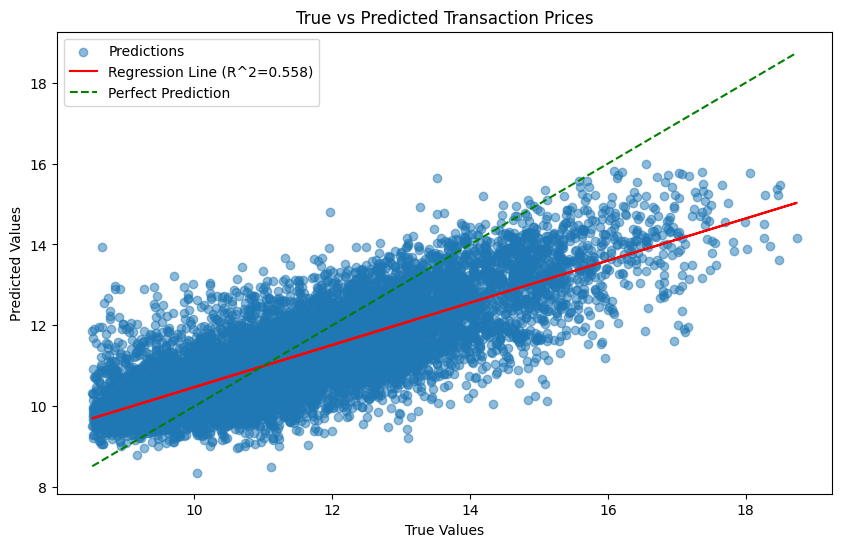

0.5212583161723393


In [95]:
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model using the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)





def fit_visualization(X, y):
  target = np.array(X, dtype=np.float64)
  prediction_numerical_model = np.array(y, dtype=np.float64)

    # Compute R-squared using sklearn
  r_squared = r2_score(target, prediction_numerical_model)
  print(f"R-squared: {r_squared}")

  # Compute regression line parameters using linregress
  slope, intercept, r_value, p_value, std_err = linregress(target, prediction_numerical_model)

  # Create a scatter plot
  plt.figure(figsize=(10, 6))
  plt.scatter(target, prediction_numerical_model, alpha=0.5, label='Predictions')


  # Plot the regression line
  plt.plot(target, slope * target + intercept, color='red', label=f'Regression Line (R^2={r_squared:.3f})')

  # Plot y=x line (perfect predictions)
  plt.plot([min(target), max(target)], [min(target), max(target)], color='green', linestyle='--', label='Perfect Prediction')

  # Labels and title
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title('True vs Predicted Transaction Prices')
  plt.legend()

  # Show the plot
  plt.show()

  print(slope)

fit_visualization(target, prediction_numerical_model)




R-squared: 0.5161832624600745


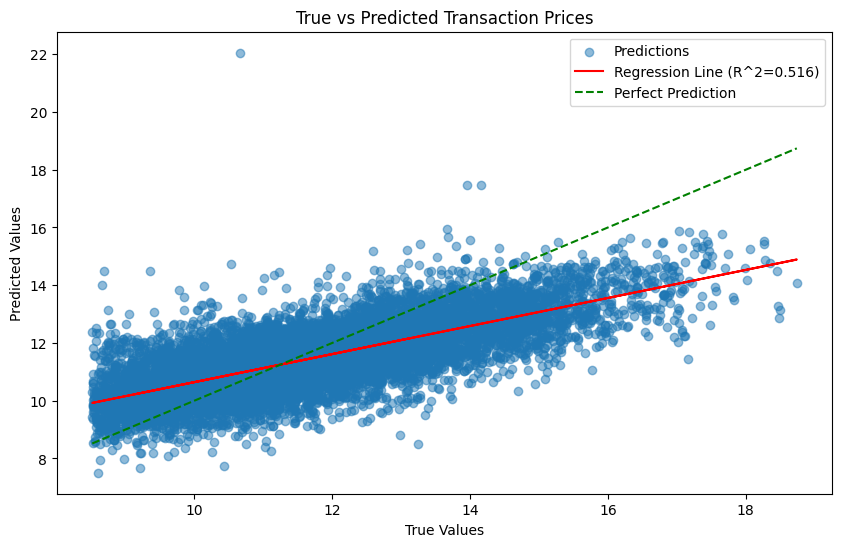

0.48594405143199676


In [96]:
fit_visualization(target, y_pred)

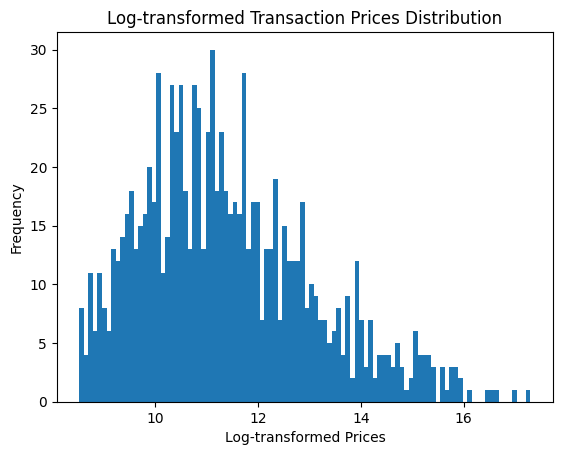

In [ ]:
# Histogram of log-transformed transaction prices

plt.hist(y_test, bins=100)
plt.title('Log-transformed Transaction Prices Distribution')
plt.xlabel('Log-transformed Prices')
plt.ylabel('Frequency')
plt.show()